In [2]:
import pandas as pd
import numpy as np
import copy
import math
from tqdm import tqdm
np.random.seed(42)
def read_file(path):
    
    f = open(path).read().splitlines()

    for i,line in enumerate(f):
        line = line.split()
        if i == 4:
            j = int(line[0])
            m = int(line[1])
            p_t = np.zeros((j,m))
            m_seq = np.zeros((j,m), dtype = np.int32)
        elif i > 4:
            for k in range(len(line)):
                if k % 2 == 0:
                    m_seq[i-5,int(k/2)] = int(line[k])
                elif k % 2 == 1:
                    p_t[i-5,int(k/2)] = int(line[k])
    
    return int(j), int(m), p_t, m_seq


In [3]:
def compute_makespan(chromosome, p_t, m_seq):
    op_count = np.zeros(p_t.shape[0], dtype = np.int32)
    j_time = np.zeros(p_t.shape[0])
    m_time = np.zeros(p_t.shape[1])

    for j in chromosome:
        completion_t = max(j_time[j], m_time[m_seq[j,op_count[j]]]) + p_t[j,op_count[j]]
        j_time[j] = completion_t
        m_time[m_seq[j,op_count[j]]] = completion_t
        op_count[j] += 1

    makespan = max(j_time)

    return makespan

In [4]:
def generate_init_pop(population_size, j, m):
    population_list = np.zeros((population_size, int(j*m)), dtype = np.int32)
    chromosome = np.zeros(j*m)
    start = 0
    for i in range(j):
        chromosome[start:start+m] = i
        start += m

    for i in range(population_size):
        np.random.shuffle(chromosome)
        population_list[i] = chromosome
    
    return population_list

In [5]:
def two_point_crossover(populationlist, crossover_rate):
    parentlist = copy.deepcopy(populationlist)
    childlist = copy.deepcopy(populationlist)
    for i in range(len(parentlist),2):
        sample_prob=np.random.rand()
        if sample_prob <= crossover_rate:
            cutpoint = np.random.choice(2, parentlist.shape[1], replace = False)
            cutpoint.sort()
            parent_1 = parentlist[i]
            parent_2 = parentlist[i+1]
            child_1 = copy.deepcopy(parent_1)
            child_2 = copy.deepcopy(parent_2)
            child_1[cutpoint[0]:cutpoint[1]] = parent_2[cutpoint[0]:cutpoint[1]]
            child_2[cutpoint[0]:cutpoint[1]] = parent_1[cutpoint[0]:cutpoint[1]]
            childlist[i] = child_1
            childlist[i+1] = child_2
    
    return parentlist, childlist

In [6]:
def job_order_implementation(parent1, parent2, select_job):
    other_job_order = []
    child = np.zeros(len(parent1))
    for j in parent2:
        if j != select_job:
            other_job_order.append(j)
    k = 0
    for i,j in enumerate(parent1):
        if j == select_job:
            child[i] = j
        else:
            child[i] = other_job_order[k]
            k += 1
    
    return child

In [7]:
def job_order_crossover(populationlist, j, crossover_rate):
    parentlist = copy.deepcopy(populationlist)
    childlist = copy.deepcopy(populationlist)
    for i in range(len(parentlist),2):
        sample_prob=np.random.rand()
        if sample_prob <= crossover_rate:
            parent_id = np.random.choice(len(populationlist), 2, replace=False)
            select_job = np.random.choice(j, 1, replace=False)[0]
            child_1 = job_order_implementation(parentlist[parent_id[0]], parentlist[parent_id[1]], select_job)
            child_2 = job_order_implementation(parentlist[parent_id[1]], parentlist[parent_id[0]], select_job)
            childlist[i] = child_1
            childlist[i+1] = child_2

    return parentlist, childlist


In [8]:
def repair(chromosome, j, m):
    job_count = np.zeros(j)
    for j in chromosome:
        job_count[j] += 1
    
    job_count = job_count - m

    much_less = [[],[]]
    is_legall = True
    for j,count in enumerate(job_count):
        if count > 0:
            is_legall = False
            much_less[0].append(j)
        elif count < 0:
            is_legall = False
            much_less[1].append(j)

    if is_legall == False:
        for m in much_less[0]:
            for j in range(len(chromosome)):
                if chromosome[j] == m:
                    less_id = np.random.choice(len(much_less[1]),1)[0]
                    chromosome[j] = much_less[1][less_id]
                    job_count[m] -= 1
                    job_count[much_less[1][less_id]] += 1

                    if job_count[much_less[1][less_id]] == 0:
                        much_less[1].remove(much_less[1][less_id])

                    if job_count[m] == 0:
                        break

In [9]:
def mutation(childlist, num_mutation_jobs, mutation_rate, p_t, m_seq):
    for chromosome in childlist:
        sample_prob = np.random.rand()
        if sample_prob <= mutation_rate:
            mutationpoints = np.random.choice(len(chromosome), num_mutation_jobs, replace = False)
            chrom_copy = copy.deepcopy(chromosome)
            for i in range(len(mutationpoints)-1):
                chromosome[mutationpoints[i+1]] = chrom_copy[mutationpoints[i]]

            chromosome[mutationpoints[0]] = chrom_copy[mutationpoints[-1]]
    
    makespan_list = np.zeros(len(childlist))
    for i,chromosome in enumerate(childlist):
        makespan_list[i] = compute_makespan(chromosome, p_t, m_seq)
    
    num_all_mut = int(0.1*len(childlist))
    zipped = list(zip(makespan_list, np.arange(len(makespan_list))))
    sorted_zipped = sorted(zipped, key=lambda x: x[0])
    zipped = zip(*sorted_zipped)
    partial_mut_id = np.asarray(list(zipped)[1])[:-num_all_mut]
    all_mut = generate_init_pop(num_all_mut, p_t.shape[0], p_t.shape[1])
    childlist = np.concatenate((all_mut,copy.deepcopy(childlist)[partial_mut_id]), axis = 0)
    

In [10]:
def selection(populationlist, makespan_list):
    num_self_select = int(0.2*len(populationlist)/2)
    num_roulette_wheel = int(len(populationlist)/2) - num_self_select
    zipped = list(zip(makespan_list, np.arange(len(makespan_list))))
    sorted_zipped = sorted(zipped, key=lambda x: x[0])
    zipped = zip(*sorted_zipped)
    self_select_id = np.asarray(list(zipped)[1])[:num_self_select]
    
    makespan_list = 1/makespan_list
    selection_prob = makespan_list/sum(makespan_list)
    roulette_wheel_id = np.random.choice(len(populationlist), size = num_roulette_wheel, p = selection_prob)
    new_population = np.concatenate((copy.deepcopy(populationlist)[self_select_id],copy.deepcopy(populationlist)[roulette_wheel_id]), axis=0)
    
    return new_population

In [11]:
def binary_selection(populationlist, makespan_list):
    new_population = np.zeros((int(len(populationlist)/2), populationlist.shape[1]), dtype = np.int32)
    
    num_self_select = int(0.1*len(populationlist)/2)
    num_binary = int(len(populationlist)/2) - num_self_select
    zipped = list(zip(makespan_list, np.arange(len(makespan_list))))
    sorted_zipped = sorted(zipped, key=lambda x: x[0])
    zipped = zip(*sorted_zipped)
    self_select_id = np.asarray(list(zipped)[1])[:num_self_select]
    
    for i in range(num_binary):
        select_id = np.random.choice(len(makespan_list), 2, replace=False)
        if makespan_list[select_id[0]] < makespan_list[select_id[1]]:
            new_population[i] = populationlist[select_id[0]]
        else:
            new_population[i] = populationlist[select_id[1]]
    
    new_population[-num_self_select:] = copy.deepcopy(populationlist)[self_select_id]
    
    return new_population


In [12]:
def adaptive_mutation(childlist, num_mutation_jobs, mutation_rate, p_t, m_seq, generation, prev_best_makespan):
    # Define adaptation parameters
    increase_threshold = 50  # Number of generations without improvement to trigger an increase
    decrease_threshold = 10  # Number of generations with improvement to trigger a decrease
    max_mutation_rate = 0.3  # Maximum allowed mutation rate
    min_mutation_rate = 0.05  # Minimum allowed mutation rate
    improvement_counter = 0
    # Evaluate makespans for the current population
    makespan_list = np.zeros(len(childlist))
    for i, chromosome in enumerate(childlist):
        makespan_list[i] = compute_makespan(chromosome, p_t, m_seq)

    # Check if there is an improvement in the best makespan
    current_best_makespan = min(makespan_list)
    if current_best_makespan < prev_best_makespan:
        improvement_counter = 0
    else:
        improvement_counter += 1

    # Adaptive mutation logic
    if improvement_counter >= increase_threshold:
        mutation_rate *= 1.5  # Increase the mutation rate
        improvement_counter = 0  # Reset the counter
    elif improvement_counter >= decrease_threshold:
        mutation_rate *= 0.5  # Decrease the mutation rate
        improvement_counter = 0  # Reset the counter

    # Ensure mutation rate is within bounds
    mutation_rate = max(min(mutation_rate, max_mutation_rate), min_mutation_rate)

    # Apply mutation with the adapted rate
    for chromosome in childlist:
        sample_prob = np.random.rand()
        if sample_prob <= mutation_rate:
            mutationpoints = np.random.choice(len(chromosome), num_mutation_jobs, replace=False)
            chrom_copy = copy.deepcopy(chromosome)
            for i in range(len(mutationpoints)-1):
                chromosome[mutationpoints[i+1]] = chrom_copy[mutationpoints[i]]

            chromosome[mutationpoints[0]] = chrom_copy[mutationpoints[-1]]

    return mutation_rate, current_best_makespan
        

In [13]:
def local_search_swap(chromosome, p_t, m_seq):
    """
    Local search operator: Swap two randomly selected jobs in the chromosome
    """
    idx1, idx2 = np.random.choice(len(chromosome), 2, replace= False)
    chromosome[idx1], chromosome[idx2]= chromosome[idx2], chromosome[idx1]
    
#def local_search_insertion(chromosome):
#    """ 
#    Insertion operation: removes random job and insert in a random position
#    """
#    idx = np.random.choice(len(chromosome))
#    job = chromosome[idx]
#    chromosome = np.delete(chromosome, idx)
#    new_idx = np.random.choice(len(chromosome) + 1)
#    chromosome = np.insert(chromosome, new_idx, job)

#def local_search_reversal(chromosome):
#    """ 
#    Reversal operation: reverses the order of jobs between two randomly selected positions
#    """
#    idx1, idx2 = np.random.choice(len(chromosome), 2, replace=False)
#    start, end = min(idx1, idx2), max(idx1, idx2)
#    chromosome[start:end+1] = chromosome[start:end+1][::-1]
    
#def local_search_double_insertion(chromosome):
#     """
#     Double insertion operation: selects two jobs at random and inserts them at two different random positions
#     """
#     idx1, idx2 = np.random.choice(len(chromosome), 2, replace=False)
#     jobs = [chromosome[idx1], chromosome[idx2]]
#     chromosome = np.delete(chromosome, [idx1, idx2])
#     new_idxs = np.random.choice(len(chromosome)+2, 2, replace=False)
#     chromosome = np.insert(chromosome, new_idxs[0], jobs[0])
#     chromosome = np.insert(chromosome, new_idxs[1], jobs[1])

# Of all the methods defined above, I finally went with local search swapping after testing all other methods and realizing it was the most optimal for our job shop scheduling problem.    
def apply_local_search (population, p_t, m_seq):
    """ 
    Apply Local search to each individual in the population
    """
    for i in range (len(population)):
        local_search_swap(population[i], p_t, m_seq)

In [14]:
# function to generate neighbors
def generate_neighbors(solution):
    neighbors=[]
    for i in range(len(solution)):
        for j in range(i+1, len(solution)):
            neighbor = solution.copy()
            neighbor[i], neighbor[j]= neighbor[j], neighbor[i]
            neighbors.append(neighbor)
    return neighbors

In [15]:
# Define a hill climbing function that will be applied at the end of the main loop for better solutions
def hill_climbing_local_search(initial_solution, p_t, m_seq):
    current_solution = initial_solution.copy()
    current_makespan = compute_makespan(current_solution, p_t, m_seq)
    
    improved = True
    while improved:
        # The loop will only continue to run as long as improvements are found. It quits when there is no longer any improvements 
        improved = False
        neighbor_solutions = generate_neighbors(current_solution)
        for neighbor in neighbor_solutions:
            new_makespan = compute_makespan(neighbor, p_t, m_seq)
            #if the neighbor solution is better, update the current solution
            if new_makespan < current_makespan:
                current_solution = neighbor
                current_makespan = new_makespan
                improved = True
    return current_solution

100%|██████████| 1000/1000 [07:37<00:00,  2.18it/s]


Makespan before final local search: 1481.0
Makespan after final hill climbing local search: 1398.0
BEST JOB ORDER: 
[ 7 14  8  8  1 14  9  4 14 12  0 13  3 11 10  1  0  6 13  6  5 14 12 10
  6  0  3  4  9  7 10  6  7 13  0 14  0 11 14  1 11  1  2  6 10 12 13 11
 14  8 13  6  1 12  8 11  6  6  1  9 10  7  0  8  7  5 14  4  1  2 13  7
 12  4  9 10  9 13  3  4 12  6  6  3  9 14 10  7  7  9  3  2  7  1  4  5
  3 10 13 11 10  4 11 14 13  0  2 12  9 14  0  1  7  4  5  5  1  9  3  3
  2  6 11  8  4 11 14  8  2  6  7  0 12  3  5 14 11  1  3 13  5  8 12  3
  2  4  9 10  0  5 11 12  8  6 13  5  7  2 10  4  0 11  9  8  6  5  2  8
 10  9  5  9  1 13 12 14  2  2 10  7  8  6 12  0 13 11  3  5  2  8  0 13
  2 12  7  4 13 12  1  2  1  4  5  3  9 10  8 11 14 10 12  8 11  9  7  5
  3  2  1  4  0  0  5  4  3]


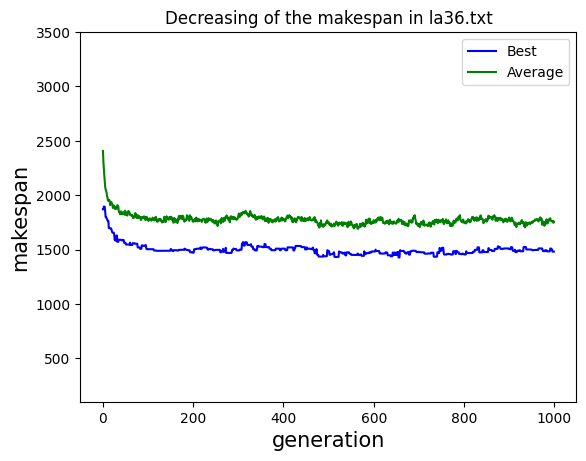

In [26]:
# I needed to change this cell into a function in order to be able to perform the optimal random seed iteration in the next cell, which is important to our final solution
#def run_generic_algorithm(seed):
np.random.seed(32)
if __name__ == "__main__":
    instance_name =  r"la36.txt"
    j, m, p_t, m_seq = read_file(instance_name)
    population_size = 100
    population_list = generate_init_pop(population_size, j ,m)
    # discovered that the optimal crossover rate was 80%
    crossover_rate = 0.8
    # discorvered that the optimal starting mutation rate was 22%
    mutation_rate = 0.22
    mutation_selection_rate = 0.1
    num_mutation_jobs=round(j*m*mutation_selection_rate)
    num_iteration = 1000
    min_makespan_record = []
    avg_makespan_record = []
    #change from min makespan to previous best makespan based on adaptive mutation
    prev_best_makespan = 9999999
    #Initialize a current best makespan as well
    current_best_makespan = 999999

    for i in tqdm(range(num_iteration)):
        parentlist, childlist = job_order_crossover(population_list, j, crossover_rate)
            
        mutation_rate, prev_best_makespan = adaptive_mutation(childlist, num_mutation_jobs, mutation_rate, p_t, m_seq, i, prev_best_makespan)
        mutation(childlist, num_mutation_jobs, mutation_rate, p_t, m_seq)
        population_list = np.concatenate((parentlist, childlist), axis=0)
        # Apply local search
        apply_local_search(population_list, p_t, m_seq)
        makespan_list = np.zeros(len(population_list))
        
        for k in range(len(population_list)):
            makespan_list[k] = compute_makespan(population_list[k], p_t, m_seq)
            
            if makespan_list[k] < prev_best_makespan:
                #change min makespan to current best makespan
                current_best_makespan = makespan_list[k]
                best_job_order = population_list[k]
            
        population_list = binary_selection(population_list, makespan_list)
        #update the min makespan record list with the current best makespan
        min_makespan_record.append(current_best_makespan)
        avg_makespan_record.append(np.average(makespan_list))
    
    # Apply hill climbing local search to the best solution found by the genetic algorithm
    best_job_order = hill_climbing_local_search(best_job_order, p_t, m_seq)
    # get final best makespan
    final_makespan = compute_makespan(best_job_order, p_t, m_seq)
    #print current best makespan
    print(f"Makespan before final local search: {current_best_makespan}")
    print(f"Makespan after final hill climbing local search: {final_makespan}")
    print(f"BEST JOB ORDER: \n{best_job_order}")
    import matplotlib.pyplot as plt
    plt.plot([i for i in range(len(min_makespan_record))],min_makespan_record,'b',label='Best')
    plt.plot([i for i in range(len(avg_makespan_record))],avg_makespan_record,'g',label='Average')
    plt.ylabel('makespan',fontsize=15)
    plt.xlabel('generation',fontsize=15)
    plt.legend()
    plt.title("Decreasing of the makespan in "+instance_name)
    plt.ylim(100, 3500)
    plt.show()
    #return current_best_makespan


In [17]:
# The commented lines below can be used to iterate through different seed values in order to get the seed that produces the best makespan
# This iterative process takes over 5 hours to complete and is no longer necessary since I have done the work and realized that seed 32 was the best
# New data may have similar behavior, but you may need to run this cell to find out the best random seed value between 0 and 50


#seed_range = range(0, 50)
#results = {}
#for seed in tqdm (seed_range):
#    makespan_result = run_generic_algorithm(seed)
#    results[seed] = makespan_result
#best_seed = min(results, key = results.get)
#best_makespan = results[best_seed] 
#print(f"Best Seed: {best_seed}, Best Makespan: {best_makespan}")

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import plotly.figure_factory as ff

# Assuming you have the necessary variables: best_job_order, p_t, m_seq

j_count = p_t.shape[0]
m_count = m_seq.shape[1]
task_colors = plt.cm.viridis(np.linspace(0, 1, j_count))

# Dictionary to store job scheduling information
j_record = {}

for i, op_id in enumerate(best_job_order):
    job_id = i % j_count  # Wrap around the job_id using modulo
    machine_id = i // j_count + 1  # Calculate the machine_id based on the job_id

    if op_id < p_t.shape[1] and op_id < m_seq.shape[1]:
        p_t_row = p_t[job_id, :op_id + 1]
        m_seq_row = m_seq[job_id, :op_id + 1]

        start_time = max(np.sum(p_t_row), np.sum(m_seq_row))
        end_time = start_time + p_t[job_id, op_id]

        # Convert start_time and end_time to timedelta format
        start_time = str(datetime.timedelta(seconds=start_time))
        end_time = str(datetime.timedelta(seconds=end_time))

        j_record[(job_id, machine_id)] = [start_time, end_time]

# Creating a list of dictionaries for DataFrame
df = []
for machine_id in range(1, m_count + 1):
    for job_id in range(j_count):
        df.append(dict(Task=f"Machine {machine_id}", Start=f'2023-11-23 {j_record[(job_id, machine_id)][0]}',
                       Finish=f'2023-11-23 {j_record[(job_id, machine_id)][1]}', Resource=f'Job {job_id + 1}'))

# Creating a DataFrame
df = pd.DataFrame(df)
df.Start = pd.to_datetime(df['Start'])
df.Finish = pd.to_datetime(df['Finish'])

# Creating Gantt Chart using Plotly
fig = ff.create_gantt(df, index_col='Resource', show_colorbar=True, group_tasks=True, showgrid_x=True,
                      title='Job Shop Schedule')
fig.show()